In [46]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
from sklearn.preprocessing import normalize

In [828]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [829]:
import rainbow
import os
import glob

## Import the jsonified transactions into a dataframe

In [830]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/'
all_files = glob.glob(os.path.join(path, "*.json"))

In [3]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

NameError: name 'all_files' is not defined

## Import just one day into a dataframe 

In [ ]:
for i in range(df.shape[0]):
        for item in df['items'][i]:
            if item[3] == 0:
                print (item)
                break

In [6]:
df = pickle.load(open('./pickles/df2018.p','rb'))

In [ ]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]
q1,q2,q3

In [119]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [120]:
df=df[df['item_count']>q3]

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201070 entries, 12 to 831282
Data columns (total 14 columns):
date              201070 non-null datetime64[ns]
gross+            201070 non-null float64
gross-            201070 non-null float64
items             201070 non-null object
net               201070 non-null float64
oper              201070 non-null int64
term              201070 non-null int64
time              201070 non-null object
trans             201070 non-null int64
type              201070 non-null object
day_of_week       201070 non-null object
month             201070 non-null int64
total_of_items    201070 non-null int64
item_count        201070 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 23.0+ MB


In [225]:

def get_depts(df):
    basket_counts =[]
    dept_dict=defaultdict(int)
    dept_list=[]
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket: 
            if item[3] not in (0,9,20,21,22,23,24,25) and item[3] < 26:
                dept_dict[item[3]] +=1
                dept_list.append(item[3])
    dept_set=set(dept_list)
    '''for i in range(0,9,20,21,22,23,24,25):
        dept_set.remove(i)
        dept'''
    return dept_set,dept_dict,basket_counts

In [226]:
dept_set,dept_dict,basket_counts = get_depts(df)

In [227]:
dept_matrix = np.zeros((df.shape[0],len(dept_set)))
df_depts= pd.DataFrame(dept_matrix,columns=dept_set)
df=df.reset_index()
df.pop('index')
col_index_dict = dict(zip(dept_set, range(len(dept_set))))
matrix = np.zeros(df_depts.shape)
matrix.shape

(201070, 17)

In [228]:
col_index_dict

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 10: 8,
 11: 9,
 12: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 19: 16}

In [229]:
    matrix_dict = defaultdict(int)
    for i in range(df.shape[0]):
        for item in df['items'][i]:
            #set matrix to boolean for item precence in basket:
            #if item[1] not in stopwords and item[3] != 12:
            #if item[1] not in stopwords and item[3] not in (12,16):
            if item[0] is not 'MP' and item[3] not in (0,9,20,21,22,23,24,25):
                if item[2]<0:
                    value=-1
                else:
                    value=1
                dept_map = {1:1,2:1,3:4,4:4,5:7,6:6,7:7,8:8,10:10,11:11,12:12,13:13,14:14,15:15,16:16,17:17,19:19,31:11,32:12,33:13,34:14,35:15,36:16,37:17,36:16,39:19}
                dept = dept_map[item[3]]
                matrix_dict[i,col_index_dict[ dept ]] += value #+ matrix_dict[(i,item[1])]
                #matrix[i,col_index_dict[ item[1] ]] = matrix[i,col_index_dict[ item[1] ]] + value
            '''if item[1] not in stopwords and item[2] > 0:
                matrix[i,col_index_dict[ item[1] ]] = 1
            if item[1] not in stopwords and item[2] < 0:
                matrix[i,col_index_dict[ item[1] ]] = 0'''
    #matrix = (matrix > 0).astype(int)
 

In [230]:
rows, cols, vals = [], [], []
for key, value in matrix_dict.items():
    rows.append(key[0])
    cols.append(key[1])
    vals.append(matrix_dict[key])
sparse_matrix = sparse.csr_matrix((vals, (rows, cols)))

In [231]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [232]:
sparse_matrix = normalize(sparse_matrix, norm='l1', axis=1)

In [243]:
def fit_NMF(sparse_matrix_,n_components_,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components_,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix_)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components_=17,max_iter=250)

In [244]:
print('iterations:',model_iter,'W shape:',W.shape,'H shape:',H.shape)

iterations: 38 W shape: (201070, 17) H shape: (17, 17)


In [245]:
w = np.zeros_like(W)
w[np.arange(len(W)), W.argmax(1)] = 1
topic_strength = np.sum(w,axis=0)
topic_strength = np.round(topic_strength/topic_strength.sum(),2)
for i,t in enumerate(topic_strength):
    print('topic %d strength: %f '%(i,t))

topic 0 strength: 0.570000 
topic 1 strength: 0.010000 
topic 2 strength: 0.010000 
topic 3 strength: 0.010000 
topic 4 strength: 0.000000 
topic 5 strength: 0.070000 
topic 6 strength: 0.070000 
topic 7 strength: 0.010000 
topic 8 strength: 0.000000 
topic 9 strength: 0.020000 
topic 10 strength: 0.020000 
topic 11 strength: 0.000000 
topic 12 strength: 0.000000 
topic 13 strength: 0.000000 
topic 14 strength: 0.050000 
topic 15 strength: 0.000000 
topic 16 strength: 0.140000 


In [246]:
H

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.89759841e-17, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.75018525e-01, 0.00000000e+00,
        1.52153364e-07, 1.73724888e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.10099489e-09, 0.00000000e+00,
        2.33254904e-15, 0.00000000e+00, 8.11024242e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.03800888e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.38706417e-16, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.38665582e-01, 1.14346906e-06,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000

In [237]:
np.round(-H,1).argsort()


array([[11, 16,  6,  8, 14,  4,  5,  2,  7, 15,  9, 10,  1, 12, 13,  3,
         0],
       [14,  9,  5,  0, 13, 12, 11, 10,  8,  7,  6,  4,  3,  2,  1, 15,
        16],
       [ 3,  6,  0,  5,  7,  9,  8,  2, 15,  1, 10, 11, 12, 13, 14,  4,
        16],
       [15, 16, 14,  7,  6,  8,  4,  3,  2,  9, 10, 11, 12, 13,  1,  5,
         0],
       [13,  0, 16,  8,  7,  3,  4,  5,  6, 15,  9, 10, 11, 12,  1, 14,
         2],
       [12,  8,  6, 14,  7, 13, 11, 10,  9,  0,  5,  4,  3,  2,  1, 15,
        16],
       [10,  8,  6, 14, 13, 12, 11,  9,  0,  7,  5,  4,  3,  2,  1, 15,
        16]])

In [238]:
filename='./departments.csv'
import csv
reader = csv.reader(open(filename, 'r'))
d = {}
'''for i in range(0,39):
    d[i]=i'''
for row in reader:
    k, v = row
    if k != 'dept':
        k=int(k)
    d[k] = v
d[0]=0
d.pop('dept')
d

{1: 'VITAMINS',
 2: 'VITAMINS_FOODSTAMP',
 3: 'BATH&BODY_FOODSTAMP',
 4: 'BATH&BODY',
 5: 'SUNDRIES_FOODSTAMP',
 6: 'HOUSEWARES',
 7: 'SUNDRIES',
 8: 'BOOKS&GIFTS',
 10: 'BEER&WINE',
 11: 'HERBS',
 12: 'PRODUCE',
 13: 'REFRIGERATED',
 14: 'CHEESE',
 15: 'PACKAGED',
 16: 'BULK',
 17: 'BAKERY',
 19: 'FROZEN',
 20: 'PAID_IN',
 21: 'BOTTLE_DEPOSIT',
 22: 'PAID_OUT',
 23: 'BAG_CREDITS',
 24: 'DISCOUNT_ADJ+',
 25: 'DISCOUNT_ADJ-',
 31: 'HERBS_NON_FOODSTAMP',
 32: 'PRODUCE_NON_FOODSTAMP',
 33: 'REFRIGERATED_NON_FOODSTAMP',
 34: 'CHEESE_NON_FOODSTAMP',
 35: 'PACKAGED_NON_FOODSTAMP',
 36: 'BULK_NON_FOODSTAMP',
 37: 'BAKERY_NON_FOODSTAMP',
 39: 'FROZEN_NON_FOODSTAMP',
 0: 0}

In [239]:
dept_names =[]
for l in dept_set:
    dept_names.append(d[l])
dept_names

['VITAMINS',
 'VITAMINS_FOODSTAMP',
 'BATH&BODY_FOODSTAMP',
 'BATH&BODY',
 'SUNDRIES_FOODSTAMP',
 'HOUSEWARES',
 'SUNDRIES',
 'BOOKS&GIFTS',
 'BEER&WINE',
 'HERBS',
 'PRODUCE',
 'REFRIGERATED',
 'CHEESE',
 'PACKAGED',
 'BULK',
 'BAKERY',
 'FROZEN']

In [240]:
H_df = pd.DataFrame(H,columns=dept_names)

In [242]:
H_df

,VITAMINS,VITAMINS_FOODSTAMP,BATH&BODY_FOODSTAMP,BATH&BODY,SUNDRIES_FOODSTAMP,HOUSEWARES,SUNDRIES,BOOKS&GIFTS,BEER&WINE,HERBS,PRODUCE,REFRIGERATED,CHEESE,PACKAGED,BULK,BAKERY,FROZEN
0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.165610,0.020318,0.204660,0.000000,0.000000,8.742221,0.000000,0.000000,0.124868,0.000000,1.117579
1,0.000000,0.0,0.0,0.000000,0.0,0.552746,0.000000,0.000000,0.000000,2.591484,0.000000,0.000000,0.000000,0.000000,8.036021,0.000000,0.000000
2,2.492601,0.0,0.0,6.625321,0.0,0.686637,2.939857,0.478525,0.079269,0.192982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.147226,0.053788,0.092535,0.000000,0.000000,0.000000,0.000000,0.000000,0.072441,8.665617,0.963948
4,0.613647,0.0,0.0,0.000000,0.0,0.040209,0.000000,0.106755,0.186931,0.000000,0.000000,0.000000,0.000000,9.605941,0.000000,0.000000,0.560550
5,0.000000,0.0,0.0,0.000000,0.0,0.039543,0.351849,0.051662,0.715548,0.000000,0.000000,0.000000,7.814947,0.000000,0.055465,0.000000,0.033867
6,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.144970,0.000000,0.187204,0.000000,8.577588,0.000000,0.000000,0.000000,0.025064,0.000000,0.000000


In [143]:
feature_names=list(dept_set).copy()
n_top_words=20
for topic in H:
    print(topic.argsort()[:-n_top_words - 1:-1])
    print()
    print ([d[i]for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()

[13 18 20 10  7 16 27  8 29  2 26 19  3 31 22  5  6  4  1  9]

['REFRIGERATED', 18, 'PAID_IN', 'BEER&WINE', 'SUNDRIES', 'BULK', 27, 'BOOKS&GIFTS', 29, 'VITAMINS_FOODSTAMP', 26, 'FROZEN', 'BATH&BODY_FOODSTAMP', 'HERBS_NON_FOODSTAMP', 'PAID_OUT', 'SUNDRIES_FOODSTAMP', 'HOUSEWARES', 'BATH&BODY', 'VITAMINS', 9]

[16 11 30  6 15 25  1  2 20  5  9 10  7  8 13  4  3 12 31 14]

['BULK', 'HERBS', 30, 'HOUSEWARES', 'PACKAGED', 'DISCOUNT_ADJ-', 'VITAMINS', 'VITAMINS_FOODSTAMP', 'PAID_IN', 'SUNDRIES_FOODSTAMP', 9, 'BEER&WINE', 'SUNDRIES', 'BOOKS&GIFTS', 'REFRIGERATED', 'BATH&BODY', 'BATH&BODY_FOODSTAMP', 'PRODUCE', 'HERBS_NON_FOODSTAMP', 'CHEESE']

[15 19 18  1 10 29  8  2  6 27  3 26 23  5 22 11  4  7  9 31]

['PACKAGED', 'FROZEN', 18, 'VITAMINS', 'BEER&WINE', 29, 'BOOKS&GIFTS', 'VITAMINS_FOODSTAMP', 'HOUSEWARES', 27, 'BATH&BODY_FOODSTAMP', 26, 'BAG_CREDITS', 'SUNDRIES_FOODSTAMP', 'PAID_OUT', 'HERBS', 'BATH&BODY', 'SUNDRIES', 9, 'HERBS_NON_FOODSTAMP']

[ 4  7  1  6  8 25 11 29  2 10 20 27  3  5 2

Topic #0:
[13, 19, 21, 10, 7, 16, 33, 8, 35, 2, 32, 20, 3, 39, 23, 5]


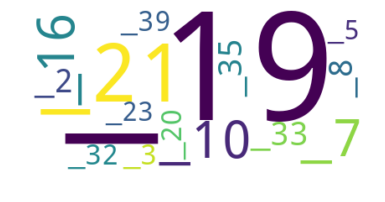

Topic #1:
[16, 11, 36, 6, 15, 31, 1, 2, 21, 5, 9, 10, 7, 8, 13, 4]


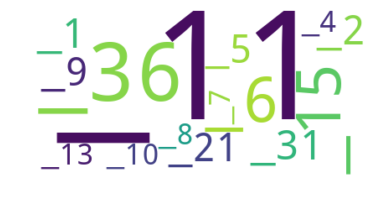

Topic #2:
[15, 20, 19, 1, 10, 35, 8, 2, 6, 33, 3, 32, 24, 5, 23, 11]


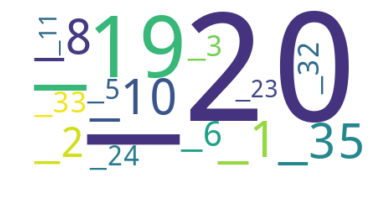

Topic #3:
[4, 7, 1, 6, 8, 31, 11, 35, 2, 10, 21, 33, 3, 5, 32, 39]


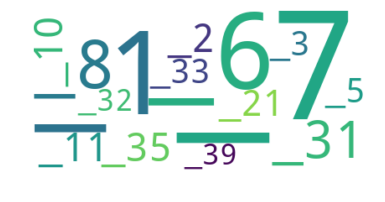

Topic #4:
[17, 19, 7, 10, 16, 8, 35, 32, 5, 23, 9, 34, 39, 11, 6, 4]


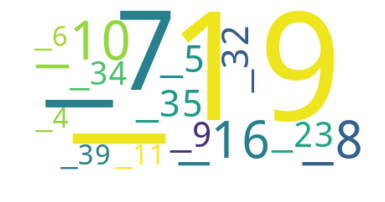

Topic #5:
[14, 10, 7, 21, 36, 8, 6, 32, 33, 15, 5, 3, 39, 34, 9, 24]


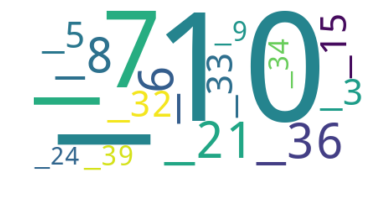

Topic #6:
[12, 10, 7, 16, 3, 32, 33, 5, 9, 13, 6, 4, 8, 2, 11, 1]


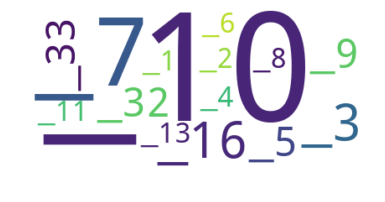

In [144]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics =[]
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)
    return topic_dict
topics = print_top_items(model,list(dept_set),16)
#print("stopwords:",stopwords,"number of topics:",len(topics))

In [145]:
topics3=topics.copy()

In [146]:
topic_compare =np.zeros([len(topics),len(topics)])

for topic in topics:
    for item in topics[topic]:
        for topic2 in topics:
            #print (item)
            #print (type(topics[topic2]))
            if item in topics[topic2]:
                topic_compare[topic,topic2]+=1
            
topic_compare


array([[16.,  8., 11., 11., 10.,  9., 10.],
       [ 8., 16.,  8., 11.,  9.,  9., 12.],
       [11.,  8., 16., 11.,  9.,  9., 10.],
       [11., 11., 11., 16., 10., 10., 12.],
       [10.,  9.,  9., 10., 16.,  9., 10.],
       [ 9.,  9.,  9., 10.,  9., 16.,  9.],
       [10., 12., 10., 12., 10.,  9., 16.]])

In [817]:
list_of_topics=[]
for topic in topics:
     list_of_topics.append(topics[topic])

In [818]:
len(topics[0])

25

In [214]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [215]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        break
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,100)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
item: ['', 'HAPPINESS', 3.29, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SUPERBERRY', 3.29, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SUPERBERRY', 3.29, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'CLEAR MIND', 3.29, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'CLEAR MIND', 3.29, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'GINGER TUMERIC', 3.29, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HAPPINESS', 3.29, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HAPPINESS', 3.29, 13]
item: 

item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'CHAMELEON ORIG 32', 10.19, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SLINGSHOT DRINK', 16.76, 13]
item: ['', 'GOOD CUL CLASSIC', 9.0, 13]
++++++++++++++++++Topic #0, basket #66+++++++++++++++++++
item: ['', 'KERRYGOLD UN', 3.99, 13]
item: ['', 'KERRYGOLD UN', 3.99, 13]
item: ['', 'HOUSE LAVENDER', 3.99, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['MR', 'SF Bag Charge', 0.30000000000000004, 20]
item: ['', 'STRAUS PLN YOG QT', 4.29, 13]
item: ['', 'HOUSE LAVENDER', 3.99, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HOUSE LAVENDER', 3.99, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HOUSE HIBISCUS', 3.99, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HOUSE HIBISCUS', 3.99, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HOUSE HIBISCUS', 3.99, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['MR', 'SF Bag Charge', 0.30000000000000004, 20]
item: ['MR', 'SF Bag Charge', 

In [427]:
df['item_count'].max()

2

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [76]:
len(list(items_set))

6576

In [75]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

[1752 6585 2198 2188 2189 2190 2191 2192 2193 2194]
[1271 6539 4820   80 4966 1929 2604 6546 2660 4806]
[6114 3455  640 2958  537   84 2189 4025 1017 4051]
[3058 2646 2476 5751 5768 6309 4302 4243 3450 6388]
[1484 4994 5017  125 4381  102 1207  435 1811 4079]


In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [72]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

4112 SINTO KIMCHI 13.54
PEPPERS RED BELL 2.75
CUCUMBERS 12.73
ORGANIC 2LB TOFU 20.95
5540 TAHINI 12.17
GINGER 4.79
GARLIC WHITE 3.01
PRODUCE SCALE 1.79
LIMES 2.0
CILANTRO 1.99
CILANTRO 1.99
BROCCOLI LOOSE 6.24
CELLO CAULIFLOWER 11.96
LEEKS 9.12
SUGAR PLUM CLAM 5.97
BEETS RED LOOSE 6.01
store 100% Bulks -34.5
store 100% Produce -70.35
store 100% Refrig -20.95


In [12]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df['CILANTRO'][10:11]

10    3.98
Name: CILANTRO, dtype: float64

In [19]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.shape

(2535, 6586)

In [22]:
df.to_pickle('02012019.pkl')

In [213]:
len(items_set)

6576

In [114]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]


In [96]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]
[[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]]


In [4]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [80]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

['', 'BLUEBERRIES', 5.99, 12]
1 
2 BLUEBERRIES
3 5.99
4 12
['', 'ALXNDRE YOGURT', 4.99, 13]
5 
6 ALXNDRE YOGURT
7 4.99
8 13
['MP', 'Worker 20% Produce', -1.2, 12]
9 MP
10 Worker 20% Produce
11 -1.2
12 12
['MP', 'Worker 20% Refrig', -1.0, 13]
13 MP
14 Worker 20% Refrig
15 -1.0
16 13


NameError: name 'plt' is not defined

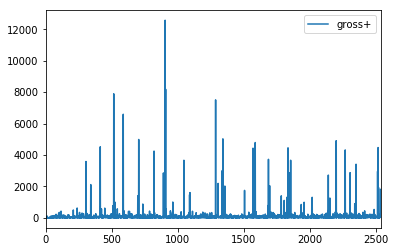

In [51]:
df[['gross+','time']].plot()
plt.show()

In [33]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

yep


In [ ]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [8]:
df=pd.read_pickle('02012019.pkl')

In [10]:
df[df['BANANAS']!=0]

,date,gross+,gross-,items,net,oper,term,time,trans,type,...,PRO BAR MINT CHOC,8213 FENNEL POWDER,OR Cooked Beets,JR Melatonin SR 12,NUT WALNUT,QT Elderbry Loz 36,SW WB Vanilla 12pk,6556 DUTCH COCOA,lvngClyBntonte 8oz,CARDAMOM BITTERS
36,2001-02-19,37.65,0.00,"[[, PASCHA UNSWT CCHIP, 4.99, 15], [, PRIMAVER...",37.65,104,5,09:16,8,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2001-02-19,108.17,0.00,"[[, FORGER PL CSH YOG, 5.59, 13], [, SO DEL UN...",108.17,42,6,09:20,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,2001-02-19,20.72,0.00,"[[, APPLES FUJI, 2.42, 12], [, 8308KEEMUN BLAC...",20.72,11,1,09:27,7,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,2001-02-19,144.42,0.00,"[[, WOODSTK BLUEBERRIE, 6.29, 19], [, EVOLUTIO...",144.42,42,6,09:30,17,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,2001-02-19,17.69,0.00,"[[, COELA ZIPPER TOTE, 9.99, 6], [, BANANAS, 2...",17.69,42,6,09:31,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,2001-02-19,224.03,0.00,"[[, APPLE JUICE, 11.39, 15], [, ORG GAL CLOVER...",224.03,104,5,09:32,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,2001-02-19,80.01,0.00,"[[, MAC HAWAI SEA SALT, 7.99, 15], [, UMLAUT C...",80.01,42,6,09:35,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2001-02-19,86.51,0.00,"[[, FLAVORG VANILLA4oz, 15.49, 15], [, SUGAR P...",86.51,34,8,09:39,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2001-02-19,285.53,0.00,"[[, VH Kids Vibe Choc, 34.4, 1], [, EZ Ultimat...",285.53,11,1,09:40,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,2001-02-19,55.73,0.00,"[[, QRT CAN JAR t101, 1.79, 6], [, QRT CAN JAR...",55.73,42,6,09:41,25,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
df.columns

Index(['date', 'gross+', 'gross-', 'items', 'net', 'oper', 'term', 'time',
       'trans', 'type'],
      dtype='object')

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [35]:
import time

time=str(time.time()).split('.')[0]
time

'1554307992'

In [20]:
from datetime import datetime as dt

In [31]:
dt.year()

TypeError: 'getset_descriptor' object is not callable